In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
# This is need so you can import larndsim without doing python setup.py install
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,'/sdf/home/s/sgaz/larnd-sim/')

In [3]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import mpl_toolkits.mplot3d.art3d as art3d

import numpy as np
import eagerpy as ep
import h5py

import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 100

In [4]:
from numpy.lib import recfunctions as rfn
import torch

def torch_from_structured(tracks):
    tracks_np = rfn.structured_to_unstructured(tracks, copy=True, dtype=np.float32)
    return torch.from_numpy(tracks_np).float()

def structered_from_torch(tracks_torch, dtype):
    return rfn.unstructured_to_structured(tracks_torch.cpu().numpy(), dtype=dtype)

### Dataset import
First of all we load the `edep-sim` output. For this sample we need to invert $z$ and $y$ axes.

In [5]:
# If you have access to a GPU, sim works trivially/is much faster
if torch.cuda.is_available():
    device = 'cuda'
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = 'cpu'

In [6]:
dir_name = '/sdf/group/neutrino/kvtsang/nd-sim/test-samples/2021-11-08/'
fname = dir_name + 'edepsim.h5'
with h5py.File(fname, 'r') as f:
    tracks = np.array(f['segments'])  

x_start = np.copy(tracks['x_start'] )
x_end = np.copy(tracks['x_end'])
x = np.copy(tracks['x'])

tracks['x_start'] = np.copy(tracks['z_start'])
tracks['x_end'] = np.copy(tracks['z_end'])
tracks['x'] = np.copy(tracks['z'])

tracks['z_start'] = x_start
tracks['z_end'] = x_end
tracks['z'] = x

In [7]:
tracks = tracks[(tracks['dEdx'] > 0.8) & (tracks['dEdx'] < 300)]

In [8]:
index = {}
all_events = np.unique(tracks['eventID'])
for ev in all_events:
    track_set = np.unique(tracks[tracks['eventID'] == ev]['trackID'])
    index[ev] = track_set  

In [9]:
def batch(index, tracks, size=10, max_seg=-1):
    n_seg = 0
    out_trk = []
    while n_seg < size:
        rand_ev = np.random.choice(list(index.keys()))
        rand_track = np.random.randint(0, len(index[rand_ev]))
        mask = (tracks['eventID']== rand_ev) & (tracks['trackID'] == index[rand_ev][rand_track])
        n_seg += np.sum(mask)
        
        out_trk.append(torch_from_structured(tracks[mask].copy()))
       
    out = torch.cat(out_trk, dim=0)
    if max_seg != -1 and len(out) > max_seg:
        idxs = np.random.permutation(np.arange(max_seg))
        return out[idxs]
    else:
        return out

## Simulation
To flexibly keep track of parameters/gradients, simulations are housed in a class `sim_with_grad`. This is derived from class versions of all the other modules. Parameters are housed in `consts`, with method `track_gradients` to promote the constants to `requires_grad=True` PyTorch tensors.

In [10]:
from larndsim.sim_with_grad import sim_with_grad

Generate <class 'larpix.configuration.configuration_v2b.Configuration_v2b'>.pixel_trim_dac using bits (0, 512)
	<function _list_property at 0x7fb5dc0f5790>((<class 'int'>, 0, 31, 64, 8)) 
Generate <class 'larpix.configuration.configuration_v2b.Configuration_v2b'>.threshold_global using bits (512, 520)
	<function _basic_property at 0x7fb5dc0f5700>((<class 'int'>, 0, 255)) 
Generate <class 'larpix.configuration.configuration_v2b.Configuration_v2b'>.csa_gain using bits (520, 521)
	<function _compound_property at 0x7fb5dc0f5820>((['csa_gain', 'csa_bypass_enable', 'bypass_caps_en'], (<class 'int'>, <class 'bool'>), 0, 1)) 
Generate <class 'larpix.configuration.configuration_v2b.Configuration_v2b'>.csa_bypass_enable using bits (521, 522)
	<function _compound_property at 0x7fb5dc0f5820>((['csa_gain', 'csa_bypass_enable', 'bypass_caps_en'], (<class 'int'>, <class 'bool'>), 0, 1)) 
Generate <class 'larpix.configuration.configuration_v2b.Configuration_v2b'>.bypass_caps_en using bits (522, 523)
	

## The simulation
Following the flow of the simulation chain, define a function which takes in the `sim_with_grad` object, runs whatever pieces of the simulation, and returns desired output.

In [11]:
def get_id_map(selected_tracks, fields):
    # Here we build a map between tracks and event IDs (no param dependence, so np should be ok)
    unique_eventIDs = np.unique(selected_tracks[:, fields.index('eventID')])
    event_id_map = np.searchsorted(unique_eventIDs,np.asarray(selected_tracks[:, fields.index('eventID')]))
    event_id_map_torch = torch.from_numpy(event_id_map).to(device)
    
    return event_id_map_torch, unique_eventIDs

In [12]:
def all_sim(sim, selected_tracks, fields, event_id_map, unique_eventIDs, return_unique_pix=False):
    selected_tracks_quench = sim.quench(selected_tracks, sim.birks, fields=fields)
    selected_tracks_drift = sim.drift(selected_tracks_quench, fields=fields)

    active_pixels_torch, neighboring_pixels_torch, n_pixels_list_ep = sim.get_pixels(selected_tracks_drift,
                                                                                     fields=fields)

    track_starts_torch, max_length_torch = sim.time_intervals(event_id_map, 
                                                              selected_tracks_drift, 
                                                              fields=fields)
    
    signals_ep = sim.tracks_current(neighboring_pixels_torch, selected_tracks_drift, 
                                          max_length_torch,
                                          fields=fields)

    unique_pix_torch = torch.empty((0, 2))
    pixels_signals_torch = torch.zeros((len(unique_pix_torch), len(sim.time_ticks)*30))

    shapes_torch = neighboring_pixels_torch.shape
    joined_torch = neighboring_pixels_torch.reshape(shapes_torch[0]*shapes_torch[1], 2)

    this_unique_pix_torch = torch.unique(joined_torch, dim=0)
    this_unique_pix_torch = this_unique_pix_torch[(this_unique_pix_torch[:,0] != -1) & (this_unique_pix_torch[:,1] != -1),:]
    unique_pix_torch = torch.cat((unique_pix_torch, this_unique_pix_torch),dim=0)

    this_pixels_signals_torch = torch.zeros((len(this_unique_pix_torch), len(sim.time_ticks)*30))
    pixels_signals_torch = torch.cat((pixels_signals_torch, this_pixels_signals_torch), dim=0)

    pixel_index_map_torch = torch.full((selected_tracks.shape[0], neighboring_pixels_torch.shape[1]), -1)
    compare_torch = (neighboring_pixels_torch[..., np.newaxis, :] == unique_pix_torch)

    indices_torch = torch.where(torch.logical_and(compare_torch[..., 0], compare_torch[...,1]))
    pixel_index_map_torch[indices_torch[0], indices_torch[1]] = indices_torch[2]
    
    pixels_signals_torch = sim.sum_pixel_signals(pixels_signals_torch,
                                                 signals_ep,
                                                track_starts_torch,
                                                pixel_index_map_torch)
    
    time_ticks_torch = torch.linspace(0, len(unique_eventIDs)*sim.time_interval[1]*3, pixels_signals_torch.shape[1]+1)

    integral_list_torch, adc_ticks_list_torch = sim.get_adc_values(pixels_signals_torch,
                                                                   time_ticks_torch,
                                                                   0)
    adc_list_torch = sim.digitize(integral_list_torch)

    if return_unique_pix:
        return adc_list_torch, unique_pix_torch
    else:
        return adc_list_torch

In [13]:
# Update parameters for training loop
def update_grad_param(sim, name, value):
    setattr(sim, name, value)
    sim.track_gradients([name])

In [14]:
# ADC counts given as list of pixels. Better for loss to embed this in the "full" pixel space
def embed_adc_list(sim, adc_list, unique_pix):
    zero_val = sim.digitize(torch.tensor(0)).item()
    new_list = torch.ones((sim.n_pixels[0], sim.n_pixels[1], adc_list.shape[1]))*zero_val

    plane_id = unique_pix[..., 0] // sim.n_pixels[0]
    unique_pix[..., 0] = unique_pix[..., 0] - sim.n_pixels[0] * plane_id

    new_list[unique_pix[:, 0].long(), unique_pix[:, 1].long(), :] = adc_list
    
    return new_list

## Define dict with ranges from the spreadsheet
https://docs.google.com/spreadsheets/d/1DLpSDgPsHeHUWCEBayYCcbLzIzd30vfBe72N-Z5vWTc/edit#gid=1247026028

In [15]:
ranges = {}
ranges['lArDensity']     = {'nom': 1.38, 'down': 1.37, 'up': 1.41}
ranges['eField']         = {'nom': 0.5, 'down': 0.45, 'up': 0.55}
ranges['vdrift']         = {'nom': 0.1648, 'down': 0.1400, 'up': 0.1800}
ranges['MeVToElectrons'] = {'nom': 4.24e4, 'down': 3.48e4, 'up': 5.13e4}
ranges['alpha']          = {'nom': 0.93, 'down': 0.85, 'up': 1.1}
ranges['beta']           = {'nom': 0.207, 'down': 0.18, 'up': 0.22}
ranges['Ab']             = {'nom': 0.8, 'down': 0.78, 'up': 0.88}
ranges['kb']             = {'nom': 0.0486, 'down': 0.04, 'up': 0.07}
ranges['lifetime']       = {'nom': 2.2e3, 'down': 300, 'up': 3e4}
ranges['long_diff']      = {'nom': 4.0e-6, 'down': 2e-6, 'up': 9e-6}
ranges['tran_diff']      = {'nom': 8.8e-6, 'down': 4e-6, 'up': 14e-6}

In [16]:
def param_l2_reg(param, sim):
    sigma = (ranges[param]['up'] - ranges[param]['down'])/2.
    return ((ranges[param]['nom']-getattr(sim, param))**2)/(sigma**2)

In [17]:
def calc_reg_loss(param_list, sim):
    reg_loss = 0.
    for param in param_list:
        reg_loss+=param_l2_reg(param, sim)
        
    return reg_loss

In [18]:
#Simulate with some set:
sim_target = sim_with_grad()
sim_target.load_detector_properties("../larndsim/detector_properties/module0.yaml",
                             "../larndsim/pixel_layouts/multi_tile_layout-2.2.16.yaml")

In [19]:
relevant_params = ['eField', 'lifetime']

In [20]:
#Setup simulation object for training -- params initialized to defaults
sim = sim_with_grad()
sim.load_detector_properties("../larndsim/detector_properties/module0.yaml",
                             "../larndsim/pixel_layouts/multi_tile_layout-2.2.16.yaml")

sim.track_gradients(relevant_params)

## Instead of varying all params by hand, draw randomly in range
These are used as the targets

In [21]:
np.random.seed(2)
for param in relevant_params:
    param_val = np.random.uniform(low=ranges[param]['down'], 
                                      high=ranges[param]['up'])
    
    setattr(sim_target, param, param_val)

In [22]:
for param in relevant_params:
    print(f'{param}, target: {getattr(sim_target, param)}, init {getattr(sim, param).item()}')

eField, target: 0.4935994902142004, init 0.5
lifetime, target: 1070.0090852883727, init 2200.0


In [23]:
#Setup simulation object for training -- params initialized to defaults
sim = sim_with_grad()
sim.load_detector_properties("../larndsim/detector_properties/module0.yaml",
                             "../larndsim/pixel_layouts/multi_tile_layout-2.2.16.yaml")

sim.track_gradients(relevant_params)

In [24]:
reg=1e-2
#Simple MSE loss between target and output
loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.SGD([#{'params' : sim.lArDensity, 'lr': 0.0},
                              {'params' : sim.eField, 'lr': 0.05},
#                              {'params' : sim.vdrift, 'lr': 0.001},
                             # {'params' : sim.MeVToElectrons, 'lr': 0.001},
                              #{'params' : sim.Ab, 'lr': 0.003},
                              #{'params' : sim.kb, 'lr': 0.001},
                              {'params' : sim.lifetime, 'lr': 1e8},
#                              #{'params' : sim.long_diff, 'lr': 1e-9},
                              #{'params' : sim.tran_diff, 'lr': 5e-9}
                              ])

                              

training_step_track = {}
for param in relevant_params:
    training_step_track[param] = []
losses = []
reg_losses = []

for param in relevant_params:
    training_step_track[param].append(getattr(sim, param).item())

In [25]:
from tqdm import tqdm

In [26]:
n_batch = 100
#Training loop
track_mem = []
for epoch in range(60):   
    for i in tqdm(range(n_batch)):
        losses_batch=[]
        optimizer.zero_grad()
        selected_tracks_torch = batch(index, tracks, size=4, max_seg=4)
        event_id_map, unique_eventIDs = get_id_map(selected_tracks_torch, tracks.dtype.names)
        selected_tracks_torch = selected_tracks_torch.to(device)
        
        target, pix_target = all_sim(sim_target, selected_tracks_torch, tracks.dtype.names, 
                                     event_id_map, unique_eventIDs,
                                  return_unique_pix=True)
            
        #Simulate with that parameter and get output
        output, pix_out = all_sim(sim, selected_tracks_torch, tracks.dtype.names, 
                                  event_id_map, unique_eventIDs,
                                  return_unique_pix=True)
        
        embed_output = embed_adc_list(sim, output, pix_out)
        embed_target = embed_adc_list(sim_target, target, pix_target)
        mem = torch.cuda.memory_allocated()/(1024*1024)
        track_mem.append(mem)
        if mem > 15000:
            continue
    
        #Calc loss between simulated and target + backprop
        loss = loss_fn(embed_output, embed_target) #+ reg*calc_reg_loss(relevant_params, sim)
        loss.backward()
    
        nan_check = torch.tensor([getattr(sim, param).grad.isnan() for param in relevant_params]).sum()
        if nan_check == 0 and loss !=0 and not loss.isnan():
            optimizer.step()
            losses_batch.append(loss.item())
                
    if len(losses_batch) > 0:
        losses.append(np.mean(losses_batch))
        print(np.mean(losses_batch))
    if epoch % 1 == 0:
        for param in relevant_params:
            print(param, getattr(sim,param).item())
        
    for param in relevant_params:
        #print(param, getattr(sim_target, param), getattr(sim, param).item())
        training_step_track[param].append(getattr(sim, param).item())

  0%|          | 0/100 [00:00<?, ?it/s]/sdf/home/s/sgaz/conda/envs/neus/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630839582/work/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
100%|██████████| 100/100 [00:10<00:00,  9.18it/s]


eField 0.499266117811203
lifetime 2135.794189453125


100%|██████████| 100/100 [00:10<00:00,  9.12it/s]


1.152591607933573e-06
eField 0.4989076256752014
lifetime 2095.546142578125


100%|██████████| 100/100 [00:10<00:00,  9.44it/s]


0.00013508407573681325
eField 0.4985754191875458
lifetime 2063.98876953125


100%|██████████| 100/100 [00:10<00:00,  9.53it/s]


eField 0.4982616603374481
lifetime 2034.165771484375


100%|██████████| 100/100 [00:10<00:00,  9.98it/s]


1.0831309964487446e-06
eField 0.4980526864528656
lifetime 2005.3353271484375


100%|██████████| 100/100 [00:10<00:00,  9.87it/s]


eField 0.497634619474411
lifetime 1967.15576171875


100%|██████████| 100/100 [00:10<00:00,  9.54it/s]


eField 0.49726390838623047
lifetime 1919.933837890625


100%|██████████| 100/100 [00:10<00:00,  9.93it/s]


eField 0.4969215989112854
lifetime 1875.1502685546875


100%|██████████| 100/100 [00:10<00:00,  9.67it/s]


8.358080094694742e-08
eField 0.496603786945343
lifetime 1834.8580322265625


100%|██████████| 100/100 [00:10<00:00,  9.75it/s]


eField 0.4964287281036377
lifetime 1804.07470703125


100%|██████████| 100/100 [00:10<00:00,  9.76it/s]


0.00016318904818035662
eField 0.49623531103134155
lifetime 1779.9569091796875


100%|██████████| 100/100 [00:09<00:00, 10.03it/s]


eField 0.4958343505859375
lifetime 1715.3221435546875


100%|██████████| 100/100 [00:10<00:00,  9.84it/s]


0.00020156828395556659
eField 0.4955006539821625
lifetime 1675.2879638671875


100%|██████████| 100/100 [00:10<00:00,  9.92it/s]


eField 0.4950770139694214
lifetime 1607.1790771484375


100%|██████████| 100/100 [00:10<00:00,  9.93it/s]


eField 0.49497076869010925
lifetime 1587.3101806640625


100%|██████████| 100/100 [00:10<00:00,  9.95it/s]


eField 0.4946347773075104
lifetime 1544.3929443359375


100%|██████████| 100/100 [00:10<00:00,  9.79it/s]


1.8225867961518816e-06
eField 0.4944818615913391
lifetime 1500.37255859375


100%|██████████| 100/100 [00:09<00:00, 10.06it/s]


eField 0.4941732585430145
lifetime 1453.1573486328125


100%|██████████| 100/100 [00:09<00:00, 10.07it/s]


4.0185382204072084e-06
eField 0.49395695328712463
lifetime 1406.6304931640625


100%|██████████| 100/100 [00:09<00:00, 10.06it/s]


3.6860733416688163e-06
eField 0.4937584400177002
lifetime 1368.5965576171875


100%|██████████| 100/100 [00:09<00:00, 10.10it/s]


5.212292307987809e-05
eField 0.49365317821502686
lifetime 1334.8804931640625


100%|██████████| 100/100 [00:09<00:00, 10.02it/s]


1.5479095054615755e-06
eField 0.49344804883003235
lifetime 1299.1197509765625


100%|██████████| 100/100 [00:10<00:00,  9.77it/s]


1.1116058885818347e-05
eField 0.4933486580848694
lifetime 1280.6458740234375


100%|██████████| 100/100 [00:10<00:00,  9.78it/s]


eField 0.49309709668159485
lifetime 1215.093994140625


100%|██████████| 100/100 [00:09<00:00, 10.16it/s]


1.877308974940206e-08
eField 0.4929825961589813
lifetime 1188.562255859375


100%|██████████| 100/100 [00:10<00:00,  9.40it/s]


5.1194618322369934e-08
eField 0.49280694127082825
lifetime 1129.689697265625


100%|██████████| 100/100 [00:10<00:00,  9.67it/s]


0.00014600301801692694
eField 0.49274101853370667
lifetime 1080.008056640625


100%|██████████| 100/100 [00:10<00:00,  9.79it/s]


eField 0.4926197826862335
lifetime 1043.748779296875


100%|██████████| 100/100 [00:10<00:00,  9.61it/s]


eField 0.4925573170185089
lifetime 1040.369140625


100%|██████████| 100/100 [00:10<00:00,  9.57it/s]


eField 0.4925096333026886
lifetime 1047.295166015625


100%|██████████| 100/100 [00:10<00:00,  9.67it/s]


3.9925912460603286e-06
eField 0.4924352765083313
lifetime 1030.6668701171875


100%|██████████| 100/100 [00:10<00:00,  9.62it/s]


eField 0.492459237575531
lifetime 1010.1922607421875


100%|██████████| 100/100 [00:10<00:00,  9.46it/s]


eField 0.49254533648490906
lifetime 1038.676513671875


100%|██████████| 100/100 [00:10<00:00,  9.74it/s]


2.027569462370593e-05
eField 0.4925024211406708
lifetime 1034.3736572265625


100%|██████████| 100/100 [00:10<00:00,  9.94it/s]


eField 0.4924779534339905
lifetime 1034.0673828125


100%|██████████| 100/100 [00:11<00:00,  9.04it/s]


2.2181609882210296e-09
eField 0.49238884449005127
lifetime 1019.5376586914062


100%|██████████| 100/100 [00:10<00:00,  9.89it/s]


eField 0.4923490285873413
lifetime 1000.6065673828125


100%|██████████| 100/100 [00:10<00:00,  9.62it/s]


3.8103500799024914e-08
eField 0.4923914670944214
lifetime 1004.6295776367188


100%|██████████| 100/100 [00:10<00:00,  9.57it/s]


eField 0.49236300587654114
lifetime 1013.2335815429688


100%|██████████| 100/100 [00:10<00:00,  9.81it/s]


eField 0.49234527349472046
lifetime 1028.1702880859375


100%|██████████| 100/100 [00:10<00:00,  9.87it/s]


3.740272222785279e-05
eField 0.49238404631614685
lifetime 1045.542236328125


100%|██████████| 100/100 [00:10<00:00,  9.68it/s]


eField 0.4922982156276703
lifetime 1029.9349365234375


100%|██████████| 100/100 [00:10<00:00,  9.92it/s]


0.0005286193918436766
eField 0.49229350686073303
lifetime 1025.3360595703125


100%|██████████| 100/100 [00:10<00:00,  9.37it/s]


4.959233024237619e-07
eField 0.49229562282562256
lifetime 1030.9669189453125


100%|██████████| 100/100 [00:10<00:00,  9.87it/s]


1.4835429283266421e-05
eField 0.492257684469223
lifetime 1005.5562133789062


100%|██████████| 100/100 [00:10<00:00,  9.80it/s]


eField 0.4922594130039215
lifetime 1006.7234497070312


100%|██████████| 100/100 [00:10<00:00,  9.80it/s]


1.2934387996210717e-06
eField 0.4923171103000641
lifetime 1019.8819580078125


100%|██████████| 100/100 [00:10<00:00,  9.64it/s]


eField 0.4922585189342499
lifetime 1008.3675537109375


100%|██████████| 100/100 [00:10<00:00,  9.66it/s]


eField 0.49215295910835266
lifetime 996.3021850585938


100%|██████████| 100/100 [00:09<00:00, 10.10it/s]


eField 0.4921853840351105
lifetime 1023.1309814453125


100%|██████████| 100/100 [00:10<00:00,  9.77it/s]


eField 0.49209651350975037
lifetime 987.3972778320312


100%|██████████| 100/100 [00:10<00:00,  9.84it/s]


6.959816801099805e-06
eField 0.49211040139198303
lifetime 1012.4835205078125


100%|██████████| 100/100 [00:10<00:00,  9.76it/s]


3.986358478869079e-06
eField 0.49210745096206665
lifetime 1002.6959228515625


100%|██████████| 100/100 [00:10<00:00,  9.91it/s]


eField 0.4920842945575714
lifetime 1016.096923828125


100%|██████████| 100/100 [00:10<00:00,  9.84it/s]


1.4697632650495507e-05
eField 0.49199825525283813
lifetime 995.7415771484375


100%|██████████| 100/100 [00:10<00:00,  9.71it/s]


4.285862814867869e-06
eField 0.4919261932373047
lifetime 979.4507446289062


100%|██████████| 100/100 [00:10<00:00,  9.80it/s]


eField 0.4918171465396881
lifetime 956.4261474609375


100%|██████████| 100/100 [00:10<00:00,  9.44it/s]


0.00032002764055505395
eField 0.4918307065963745
lifetime 957.4189453125


100%|██████████| 100/100 [00:09<00:00, 10.01it/s]


2.3855957351770485e-06
eField 0.49183768033981323
lifetime 964.3304443359375


100%|██████████| 100/100 [00:09<00:00, 10.05it/s]


7.047662165859947e-06
eField 0.4918246269226074
lifetime 953.89306640625


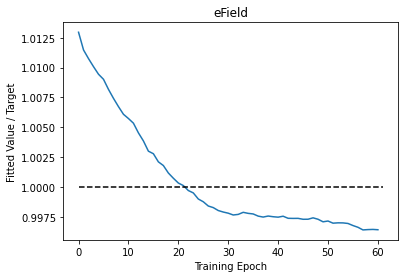

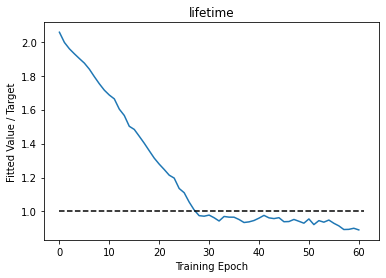

In [32]:
for param in relevant_params:
    plt.plot(np.asarray(training_step_track[param])/getattr(sim_target, param))
    plt.plot([0, len(training_step_track[param])], [1, 1], c='k', ls='dashed')
    plt.ylabel('Fitted Value / Target')
    plt.title(param)
    plt.xlabel('Training Epoch')
    plt.show()